### Tasks
* Implement Faiss - (create a util file using code given by gaurav and import here) 
* Implement Near Neighbor Sampling 
* plot the gradients for each batch (==1, should be high) and for the entire dataset(should be low) at different interesting epochs 
* Figure out how to calculate efficient per sample gradient 


In [ ]:
pip install faiss-cpu --no-cache

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#replace with pytorch lightning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

ModuleNotFoundError: No module named 'seaborn'

In [2]:
df = pd.read_csv("data/winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [1]:
#converting to vector
l=df.to_numpy()
np.save("vector_data",l);

NameError: name 'df' is not defined

In [ ]:
from indx import *
from query import *

In [ ]:
#creating FAISS index
index("/vector_data.npy","IVF16384,PQ96")

<AxesSubplot:xlabel='quality', ylabel='count'>

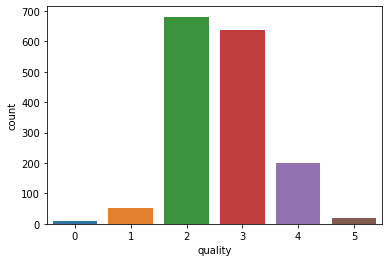

In [5]:
sns.countplot(x = 'quality', data=df)

In [4]:
class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

idx2class = {v: k for k, v in class2idx.items()}

df['quality'].replace(class2idx, inplace=True)

In [ ]:
## Create Hash tables for different classes start with one table, choose k


In [6]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [7]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [8]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [9]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

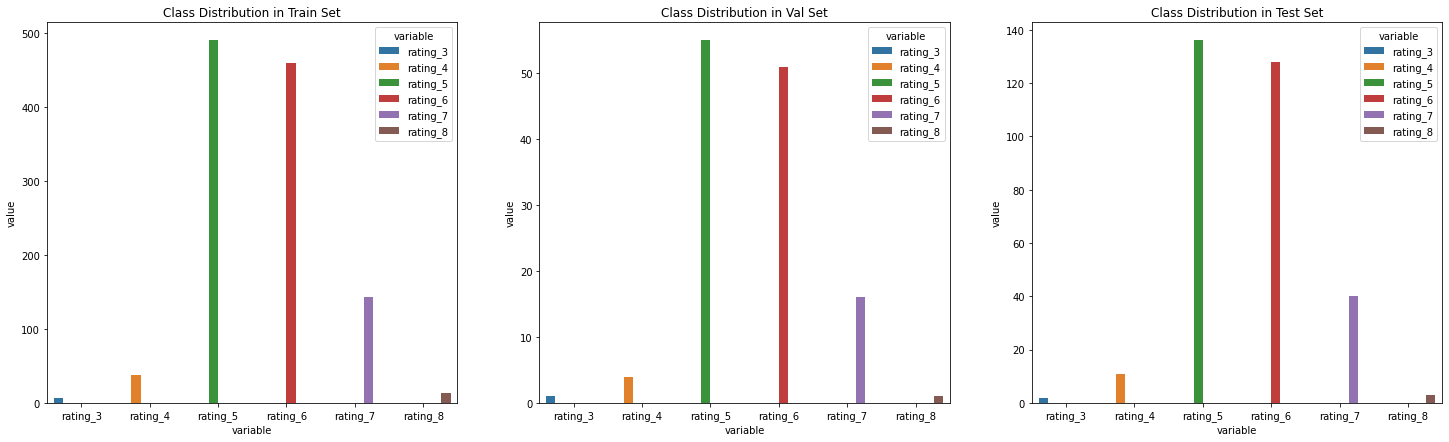

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [11]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [12]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [13]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.1429, 0.0263, 0.0020, 0.0022, 0.0070, 0.0714])


In [14]:
class_weights_all = class_weights[target_list]

In [ ]:
## insert weighted sampler with your own sampler

In [15]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [16]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 6

In [17]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [18]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [21]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [22]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [23]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.71681 | Val Loss: 2.27326 | Train Acc: 38.472| Val Acc: 4.688
Epoch 002: | Train Loss: 0.42076 | Val Loss: 2.42841 | Train Acc: 43.139| Val Acc: 3.125
Epoch 003: | Train Loss: 0.35892 | Val Loss: 2.62007 | Train Acc: 45.028| Val Acc: 3.906
Epoch 004: | Train Loss: 0.33990 | Val Loss: 2.70207 | Train Acc: 46.153| Val Acc: 3.906
Epoch 005: | Train Loss: 0.27674 | Val Loss: 2.60593 | Train Acc: 48.014| Val Acc: 3.906
Epoch 006: | Train Loss: 0.29390 | Val Loss: 2.55091 | Train Acc: 49.458| Val Acc: 4.688
Epoch 007: | Train Loss: 0.24432 | Val Loss: 2.60573 | Train Acc: 50.625| Val Acc: 5.469
Epoch 008: | Train Loss: 0.26620 | Val Loss: 2.67030 | Train Acc: 50.208| Val Acc: 6.250
Epoch 009: | Train Loss: 0.21897 | Val Loss: 2.51459 | Train Acc: 52.431| Val Acc: 7.031
Epoch 010: | Train Loss: 0.24444 | Val Loss: 2.39586 | Train Acc: 52.847| Val Acc: 7.031
Epoch 011: | Train Loss: 0.21280 | Val Loss: 2.41460 | Train Acc: 53.278| Val Acc: 7.812
Epoch 012: | Train Lo

Epoch 093: | Train Loss: 0.08050 | Val Loss: 1.53737 | Train Acc: 70.583| Val Acc: 38.281
Epoch 094: | Train Loss: 0.09608 | Val Loss: 1.67409 | Train Acc: 70.972| Val Acc: 30.469
Epoch 095: | Train Loss: 0.07359 | Val Loss: 1.62686 | Train Acc: 71.986| Val Acc: 32.812
Epoch 096: | Train Loss: 0.09217 | Val Loss: 1.75001 | Train Acc: 72.694| Val Acc: 29.688
Epoch 097: | Train Loss: 0.08408 | Val Loss: 1.54952 | Train Acc: 74.042| Val Acc: 35.938
Epoch 098: | Train Loss: 0.09533 | Val Loss: 1.73346 | Train Acc: 72.431| Val Acc: 31.250
Epoch 099: | Train Loss: 0.07427 | Val Loss: 1.58855 | Train Acc: 72.292| Val Acc: 37.500
Epoch 100: | Train Loss: 0.07653 | Val Loss: 1.53840 | Train Acc: 72.014| Val Acc: 34.375
Epoch 101: | Train Loss: 0.08628 | Val Loss: 1.59892 | Train Acc: 71.833| Val Acc: 36.719
Epoch 102: | Train Loss: 0.11254 | Val Loss: 1.55892 | Train Acc: 73.125| Val Acc: 37.500
Epoch 103: | Train Loss: 0.07326 | Val Loss: 1.57386 | Train Acc: 73.847| Val Acc: 41.406
Epoch 104:

Epoch 185: | Train Loss: 0.05294 | Val Loss: 1.45065 | Train Acc: 75.278| Val Acc: 39.844
Epoch 186: | Train Loss: 0.06315 | Val Loss: 1.53183 | Train Acc: 75.417| Val Acc: 36.719
Epoch 187: | Train Loss: 0.05979 | Val Loss: 1.39849 | Train Acc: 74.944| Val Acc: 42.188
Epoch 188: | Train Loss: 0.06819 | Val Loss: 1.81824 | Train Acc: 76.181| Val Acc: 32.812
Epoch 189: | Train Loss: 0.08946 | Val Loss: 1.55718 | Train Acc: 75.111| Val Acc: 39.844
Epoch 190: | Train Loss: 0.07074 | Val Loss: 1.47859 | Train Acc: 76.403| Val Acc: 38.281
Epoch 191: | Train Loss: 0.08495 | Val Loss: 1.62753 | Train Acc: 75.111| Val Acc: 32.812
Epoch 192: | Train Loss: 0.07671 | Val Loss: 1.56690 | Train Acc: 75.264| Val Acc: 32.031
Epoch 193: | Train Loss: 0.07102 | Val Loss: 1.53697 | Train Acc: 75.875| Val Acc: 30.469
Epoch 194: | Train Loss: 0.06617 | Val Loss: 1.55127 | Train Acc: 74.708| Val Acc: 37.500
Epoch 195: | Train Loss: 0.09041 | Val Loss: 1.47457 | Train Acc: 75.972| Val Acc: 44.531
Epoch 196:

Epoch 277: | Train Loss: 0.04917 | Val Loss: 1.57376 | Train Acc: 79.153| Val Acc: 39.844
Epoch 278: | Train Loss: 0.05634 | Val Loss: 1.49094 | Train Acc: 76.611| Val Acc: 40.625
Epoch 279: | Train Loss: 0.06179 | Val Loss: 1.49447 | Train Acc: 78.264| Val Acc: 42.969
Epoch 280: | Train Loss: 0.05717 | Val Loss: 1.46634 | Train Acc: 78.694| Val Acc: 40.625
Epoch 281: | Train Loss: 0.06079 | Val Loss: 1.58084 | Train Acc: 76.444| Val Acc: 38.281
Epoch 282: | Train Loss: 0.06627 | Val Loss: 1.60779 | Train Acc: 76.319| Val Acc: 38.281
Epoch 283: | Train Loss: 0.04951 | Val Loss: 1.40479 | Train Acc: 78.194| Val Acc: 46.875
Epoch 284: | Train Loss: 0.06178 | Val Loss: 1.46439 | Train Acc: 79.153| Val Acc: 42.969
Epoch 285: | Train Loss: 0.06982 | Val Loss: 1.59886 | Train Acc: 76.889| Val Acc: 36.719
Epoch 286: | Train Loss: 0.06343 | Val Loss: 1.66824 | Train Acc: 76.556| Val Acc: 39.844
Epoch 287: | Train Loss: 0.05466 | Val Loss: 1.49878 | Train Acc: 76.139| Val Acc: 45.312
Epoch 288:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

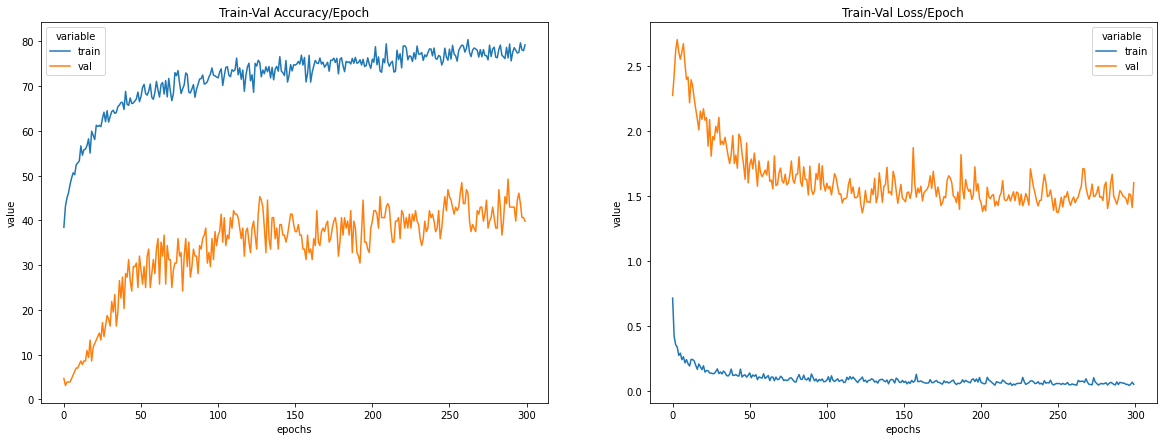

In [24]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [25]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:>

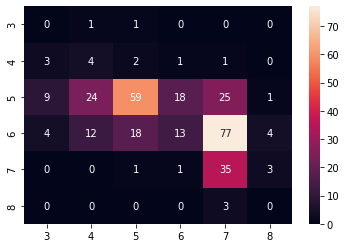

In [26]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [27]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.10      0.36      0.15        11
           2       0.73      0.43      0.54       136
           3       0.39      0.10      0.16       128
           4       0.25      0.88      0.39        40
           5       0.00      0.00      0.00         3

    accuracy                           0.35       320
   macro avg       0.24      0.30      0.21       320
weighted avg       0.50      0.35      0.35       320

